In [1]:
import numpy as np

import cv2
import sys
import torch

# from effdet import create_model_from_config
from hydra.utils import instantiate
from omegaconf import OmegaConf
from PIL import Image
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [2]:
sys.path.append('../src')

In [3]:
from predict import create_dataset
from data.loader import fast_collate
from data.sampler import CustomSampler
from models.efficient_det import create_model_from_config
from utils.visualize import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [4]:
def draw_bboxes(image, bboxes, color, box_format='coco', yxyx=False):
    if yxyx:
        # yxyx -> xyxy
        bboxes = bboxes[:, [1,0,3,2]]
    
    for box in bboxes:
        pt1 = tuple(box[:2])
        if box_format == 'coco':
            pt2 = tuple(box[:2] + box[2:])
        elif box_format == 'pascal_voc':
            pt2 = tuple(box[2:])
        else:
            raise AttributeError("Lel, kek, no {} for you :p".format(box_format))
            
        cv2.rectangle(image, pt1, pt2, color, 1)

In [5]:
conf = OmegaConf.load('../config/predict.yaml')
base_conf = OmegaConf.load('../config/model/effdet/base.yaml')
effdet_d3_conf = OmegaConf.load('../config/model/effdet/tf_d3.yaml')
conf = OmegaConf.merge(base_conf, effdet_d3_conf, conf)

In [6]:
ds = create_dataset(conf.data)

Found 10 images


In [7]:
dl = torch.utils.data.DataLoader(ds, batch_size=10, shuffle=False, drop_last=False)

In [8]:
conf.model.params.config

{'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'act_type': 'swish', 'separable_conv': True, 'apply_bn_for_resampling': True, 'conv_after_downsample': False, 'conv_bn_relu_pattern': False, 'use_native_resize_op': False, 'pooling_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'delta': 0.1, 'box_loss_weight': 50.0, 'name': 'tf_efficientdet_d3', 'backbone_name': 'tf_efficientnet_b3', 'backbone_args': {'drop_path_rate': 0.2}, 'image_size': 896, 'fpn_channels': 160, 'fpn_cell_repeats': 6, 'box_class_repeats': 4, 'pad_type': 'same', 'redundant_bias': True, 'url': 'https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d3-b0ea2cbc.pth', 'num_classes': 1, 'pretrained_backbone': False}

In [9]:
# model = create_model_from_config(
#     conf.model.params.config, 
#     bench_name='predict', 
# )

In [10]:
model = instantiate(conf.model)

In [11]:
device = torch.device('cuda:1')
model = model.to(device)

In [12]:
state_dict = torch.load('/media/dmitry/data/weights/wheat/005_d3_amp/checkpoint_33720_ema.pth')
# state_dict = {k[6:]: v for k, v in state_dict['model'].items() if "s.boxes" not in k}
model.model.load_state_dict(state_dict)

<All keys matched successfully>

In [13]:
model.eval()
_ = model.requires_grad_(False)

In [14]:
mean = torch.tensor(list(conf.data.mean)).to(device).view(1, 3, 1, 1).mul_(255)
std = torch.tensor(list(conf.data.std)).to(device).view(1, 3, 1, 1).mul_(255)

In [15]:
data_iter = iter(dl)

In [16]:
images, image_ids, meta = next(data_iter)

In [17]:
images_gpu = images.permute(0, 3, 1, 2).to(device).float().sub_(mean).div_(std)

img_scale_gpu = meta['img_scale'].to(dtype=torch.float, device=device)

assert len(meta['img_size']) == 2
img_size_gpu = torch.stack(meta['img_size'], dim=1).to(dtype=torch.float, device=device)

In [18]:
predictions = model(images_gpu, img_scale_gpu, img_size_gpu)

In [19]:
predictions[:, :, 4]

tensor([[0.2083, 0.2073, 0.1789, 0.1666, 0.1654, 0.1466, 0.1388, 0.1374, 0.1256,
         0.1219, 0.1093, 0.1049, 0.0918, 0.0865, 0.0671, 0.0668, 0.0645, 0.0618,
         0.0512, 0.0474, 0.0471, 0.0469, 0.0468, 0.0465, 0.0461, 0.0456, 0.0450,
         0.0441, 0.0434, 0.0431, 0.0423, 0.0417, 0.0404, 0.0400, 0.0398, 0.0398,
         0.0396, 0.0383, 0.0382, 0.0381, 0.0378, 0.0367, 0.0363, 0.0361, 0.0359,
         0.0347, 0.0345, 0.0343, 0.0343, 0.0338, 0.0335, 0.0335, 0.0335, 0.0335,
         0.0334, 0.0331, 0.0331, 0.0328, 0.0326, 0.0320, 0.0318, 0.0318, 0.0316,
         0.0309, 0.0309, 0.0308, 0.0307, 0.0305, 0.0304, 0.0301, 0.0297, 0.0296,
         0.0294, 0.0293, 0.0289, 0.0289, 0.0289, 0.0288, 0.0288, 0.0287, 0.0285,
         0.0282, 0.0279, 0.0279, 0.0279, 0.0277, 0.0275, 0.0274, 0.0272, 0.0269,
         0.0268, 0.0268, 0.0268, 0.0266, 0.0265, 0.0264, 0.0264, 0.0264, 0.0262,
         0.0261],
        [0.2712, 0.2622, 0.2186, 0.2180, 0.2140, 0.2140, 0.2125, 0.2071, 0.2023,
         0

In [20]:
images.shape

torch.Size([10, 896, 896, 3])

torch.Size([17, 4])


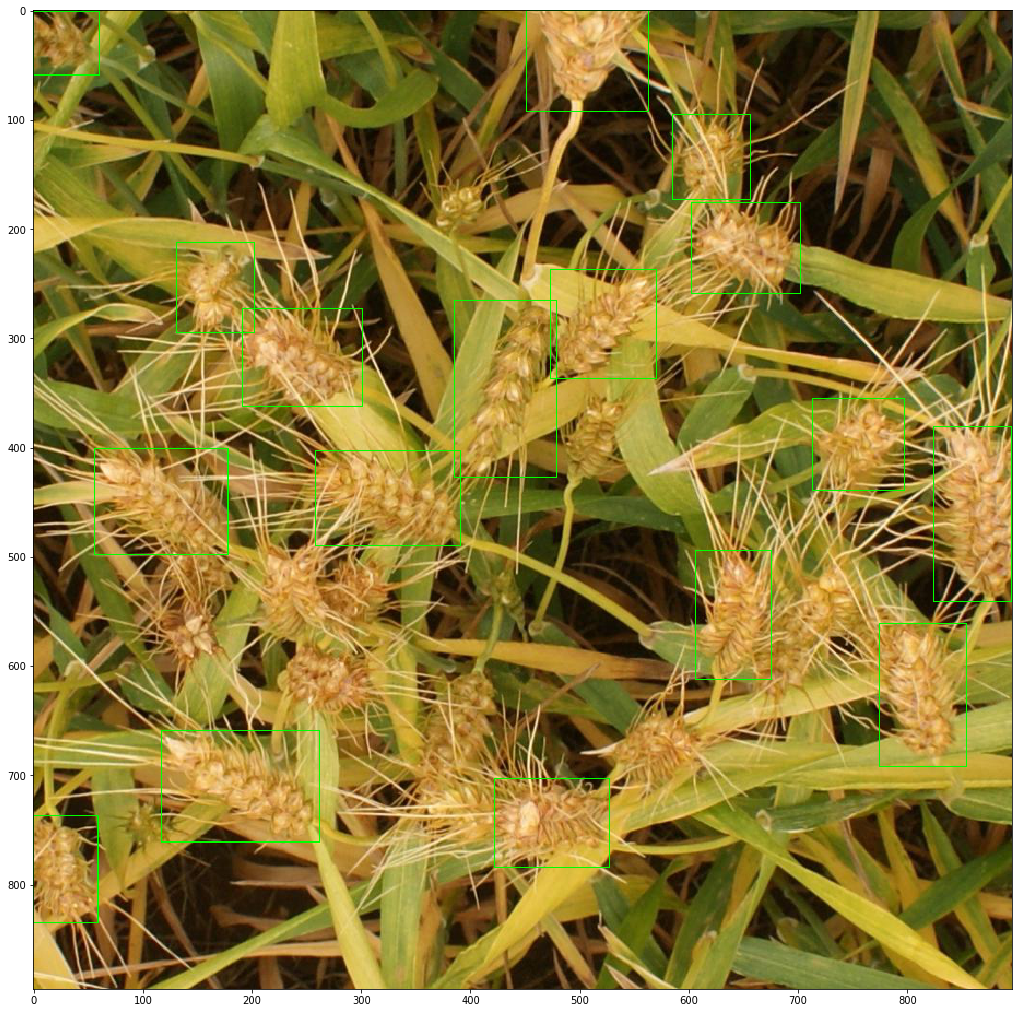

In [37]:
i = 5
score_thresh = 0.08

preds = predictions[i, :, :]
mask = preds[:, 4] >= score_thresh
preds = preds[mask, :4]
print(preds.shape)

preds = preds / img_scale_gpu[i]
preds = preds.cpu().numpy()

image = images_gpu[i] * std[0] + mean[0]
image = image.permute(1, 2, 0).cpu().numpy().astype(np.uint8)

draw_bboxes(image, preds, (0, 255, 0), box_format='coco')

plt.figure(figsize=(18, 18))
plt.imshow(image)